# Lab 4 - Part D: Face detection with logistic regression
The goal of this part of the practical is to implement logistic regression for classifying faces and non-faces. 

**TO DO:** This is a complete working bit of code. Your goals are to:
1. Look at the code and understand it
2. Investigate what happens as you increase the amount of training data - try 750, 1000, 1500, 2000, 3000, 4000 examples.  Does it generalize better?
3. Try learning with gradient descent with 4000 examples. What happens?
4. Convert this to a non-linear logistic regression algorithm by transforming the data before running the routine (see the '`transform`' method of the '`LogisticRegression`' class). Write a routine to transform each data point to a 500x1  vector by evaluating it against 500 radial basis functions.  

    The centers of these functions can be the first 500 data points.  You should experiment with the standard deviation, but somewhere in the range 1-100 should be a good start.
    
    **Note:** since this non-linear model will be largely the same as the linear version, you may want to create a sub-class that inherits from '`LogisticRegression`', and only overrides the '`transform`' method.

### Import modules

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.io import loadmat
from scipy.special import expit as sigmoid

from functions import LogisticRegressionNLL
from optimisation import SteepestDescent, NewtonMethod, optimise
from utils import add_bias, visualise_faces

# Create data loader

In [2]:
class DataLoader:
    def __init__(self, filename):
        self.data = loadmat(filename)
        self.training_images = self.data['x'].transpose(2, 0, 1).astype(np.float32) / 256
        self.training_labels = self.data['y'].squeeze()
        self.testing_images = self.data['xTest'].transpose(2, 0, 1).astype(np.float32) / 256
        self.testing_labels = self.data['yTest'].squeeze()

    def training(self, num_examples=None):
        return self.training_images[slice(num_examples)], self.training_labels[slice(num_examples)]

    def testing(self, num_examples=None):
        return self.testing_images[slice(num_examples)], self.testing_labels[slice(num_examples)]

# Define logistic regression model

In [3]:
class LogisticRegression:
    def __init__(self, dimensions):
        self.phi = add_bias(1e-4 * np.random.randn(dimensions, 1))

    def transform(self, image):
        return add_bias(image.flatten())

    def __call__(self, images):
        x = np.stack([self.transform(image) for image in images], axis=1)
        return sigmoid(self.phi.T @ x)


    def train(self, data, max_iterations, optimiser, tolerance=1e-8):
        images, labels = data
        x = np.stack([self.transform(image) for image in images], axis=1)
        phi_opt, _ = optimise(self.phi, tolerance, function=LogisticRegressionNLL(x, labels),
                              optimiser=optimiser, max_iterations=max_iterations)
        self.phi = phi_opt[-1]

In [117]:
class NonLinearLogisticRegression(LogisticRegression):
    def __init__(self, dimensions, std_dev):
        super().__init__(dimensions)
        self.std_dev = std_dev

    def transform(self, image):
        flat_image = image.flatten()
        # extract the first 500 data points as the centers of the following function
        centers = self.training_images[:500].reshape(500, -1)
        #The Euclidean distance between flat_image and the i-th center point
        distances = np.linalg.norm(flat_image - centers, axis=1)
        #trans each data point to a 500 * 1
        #by evaluating it against 500 radial basis functions(normal function)
        transformed_image = np.exp(- (distances ** 2) / (2 * self.std_dev ** 2))
        transformed_image_with_bias = add_bias(transformed_image)
        
        return transformed_image_with_bias

    def train(self, data, max_iterations, optimiser, tolerance=1e-8):
        self.training_images, _ = data
        super().train(data, max_iterations, optimiser, tolerance)


# Load and inspect data

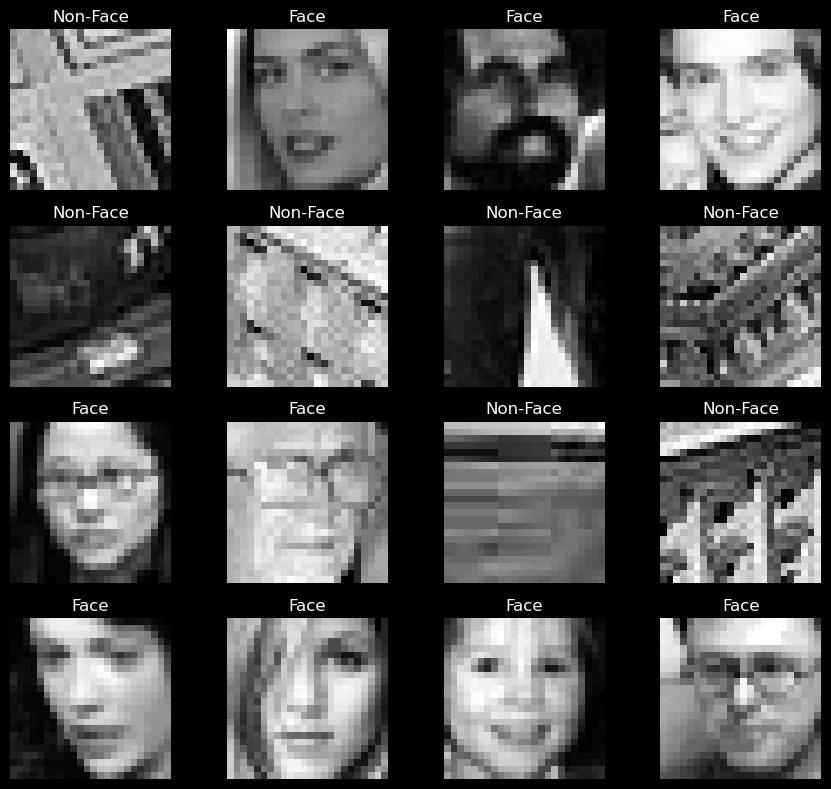

In [4]:
np.random.seed(2)
data = DataLoader('FaceDetectData.mat')

visualise_faces(data.training())

# Train the model
We define the model we are fitting to be logistic regression for 576-dimensional data, i.e. flattened vectors of the 24x24 pixel images. The model is trained using a subset of the training data, and its parameters are updated internally. You can see in the [previous section](#Define-logistic-regression-model) where we defined the model how this is implemented, and verify that it is just an abstraction of what we did in Parts B and C.

In [112]:
model = LogisticRegression(dimensions=24*24)

In [113]:
#model.train(data.training(num_examples=600), max_iterations=50, optimiser=NewtonMethod)
#model.train(data.training(num_examples=4000), max_iterations=50, optimiser=SteepestDescent)
model.train(data.training(num_examples=4000), max_iterations=50, optimiser=NewtonMethod)

Iteration    1, Function 885.2194595338607
Iteration    2, Function 517.6109862047986
Iteration    3, Function 342.4621452265329
Iteration    4, Function 298.5126351212367
Iteration    5, Function 265.1721661231488
Iteration    6, Function 238.9197735340611
Iteration    7, Function 214.10334830304615
Iteration    8, Function 210.833691545837
Iteration    9, Function 199.06819013034107
Iteration   10, Function 188.50970283435953
Iteration   11, Function 176.03668356993674
Iteration   12, Function 166.01581456728076
Iteration   13, Function 152.87440031757208
Iteration   14, Function 143.01648957080138
Iteration   15, Function 132.1193419313358
Iteration   16, Function 119.16003280453346
Iteration   17, Function 109.36034419187891
Iteration   18, Function 107.41668080997658
Iteration   19, Function 104.98790222745009
Iteration   20, Function 104.1723102225194
Iteration   21, Function 102.7914270552987
Iteration   22, Function 101.26069620020726
Iteration   23, Function 101.24762358008682

# Inference and evaluation
Now that it has been trained, calling the model as a function on images will output the probability of that image being a face or a non-face. This is compared against the ground truth labels for accuracy, and can be visually verified also.

In [114]:
prediction = model(data.training_images) > 0.5
correct_prediction = prediction == data.training_labels
print('Training Data: Classified {:3.3f}% correct'.format(100 * correct_prediction.mean()))

Training Data: Classified 93.013% correct


Test Data: Classified 87.700% correct


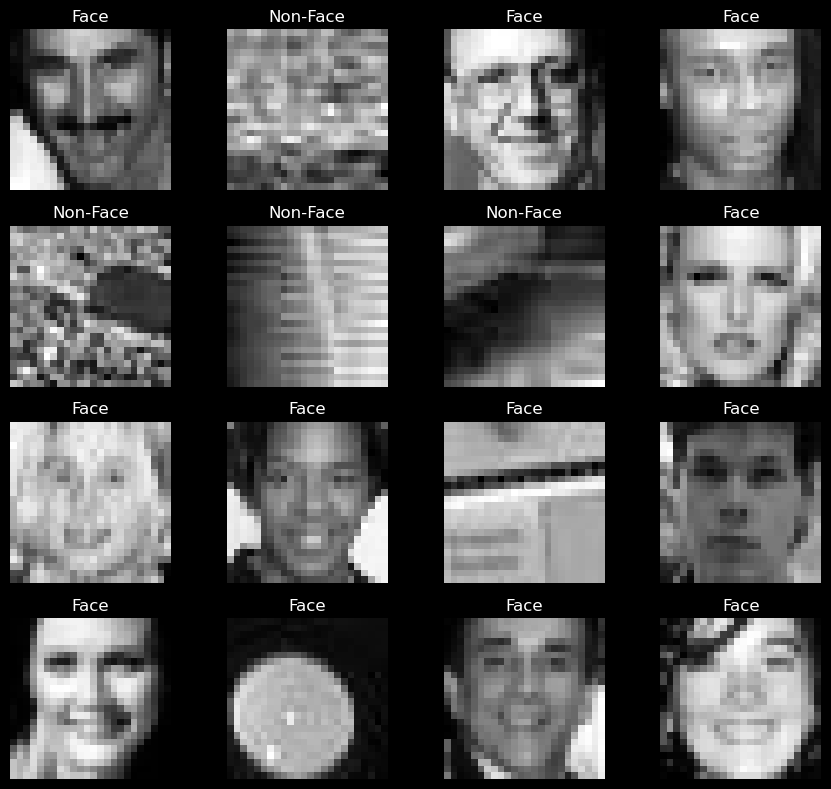

In [115]:
prediction = model(data.testing_images) > 0.5
correct_prediction = prediction == data.testing_labels
print('Test Data: Classified {:3.3f}% correct'.format(100 * correct_prediction.mean()))

visualise_faces((data.testing_images, prediction.squeeze()))

Iteration    1, Function 754.7852826733302
Iteration    2, Function 413.9808562875501
Iteration    3, Function 218.49924651228804
Iteration    4, Function 158.5544204567101
Iteration    5, Function 109.36080421670798
Iteration    6, Function 83.12664153529087
Iteration    7, Function 52.75847186486012
Iteration    8, Function 35.057698889842115
Iteration    9, Function 24.26874154454943
Iteration   10, Function 16.650155048894288
Iteration   11, Function 11.095796450898508
Iteration   12, Function 7.19506448301598
Iteration   13, Function 5.07656986460434
Iteration   14, Function 3.6028368018888735
Iteration   15, Function 3.112609252812871
Iteration   16, Function 2.2420155707254255
Iteration   17, Function 1.442774790995979
Iteration   18, Function 1.1183919343051894
Iteration   19, Function 0.8403336012718371
Iteration   20, Function 0.6878777925756775
Iteration   21, Function 0.4802102550846311
Iteration   22, Function 0.285633571233065
Iteration   23, Function 0.2058423164425986
I

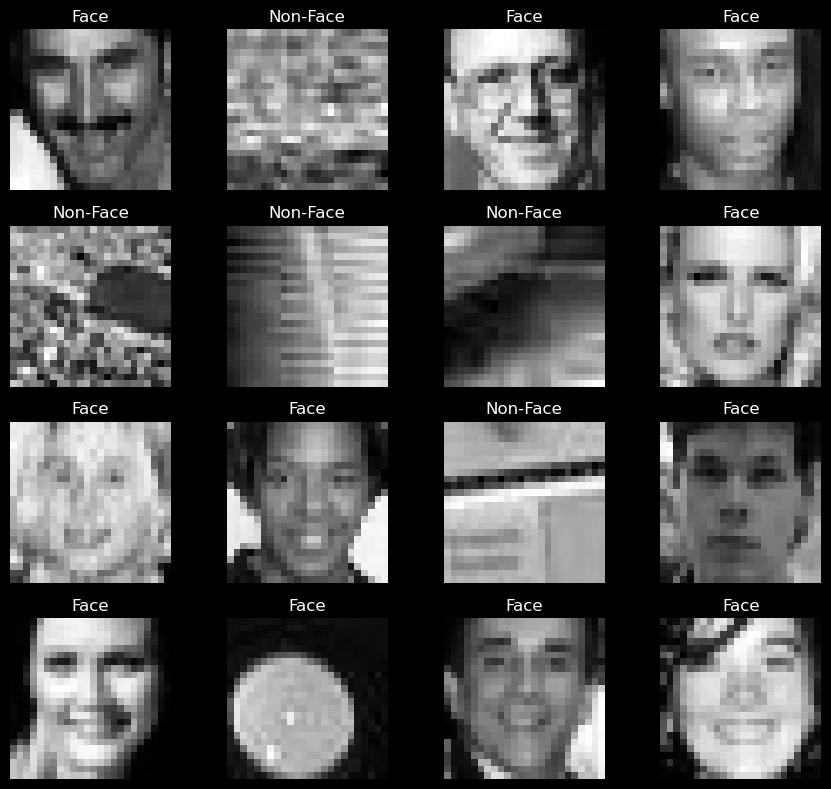

In [118]:
#Question 4
non_linear_model = NonLinearLogisticRegression(dimensions=500, std_dev=50)
non_linear_model.train(data.training(num_examples=4000), max_iterations=50, optimiser=NewtonMethod)

#training data
prediction = non_linear_model(data.training_images) > 0.5
correct_prediction = prediction == data.training_labels
print('Training Data: Classified {:3.3f}% correct'.format(100 * correct_prediction.mean()))
#test data
prediction = non_linear_model(data.testing_images) > 0.5
correct_prediction = prediction == data.testing_labels
print('Test Data: Classified {:3.3f}% correct'.format(100 * correct_prediction.mean()))

visualise_faces((data.testing_images, prediction.squeeze()))